# reg_mul = 0.004

What is the behaviour of the map of the token CLS when we regularize the model.

In [1]:
# preparation of the environment
%load_ext autoreload
%autoreload 2

import os
from os import path
# set the repository to the git repository
cwd = os.getcwd().split(os.path.sep)
while cwd[-1] != "stage_4_gm":
    os.chdir("..")
    cwd = os.getcwd().split(os.path.sep)
print(">> the git rep : ", end="")
print(os.getcwd())

# the folder where we will save our data
foler_name = "reg_mul=0.004"
plots_folder = os.path.join(os.getcwd(), '.cache', 'plots')
graph_folder = path.join(plots_folder, foler_name)
if not path.exists(graph_folder):
    os.mkdir(graph_folder)

print(f">> the plots location : {graph_folder}")

import pandas as pd
import torch
import numpy as np
import pickle
from tqdm import tqdm
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt

from regularize_training_bert import BertNliRegu
from custom_data_set import SnliDataset
from custom_data_set import test_dir, dev_dir, train_dir
from torch.utils.data import DataLoader

# --> from this environment
from attention_algorithms.raw_attention import RawAttention
from attention_algorithms.attention_metrics import normalize_attention

ckp = path.join(".cache", "logs", "igrida_trained", "reg_mul=0.004", "best.ckpt")
model = BertNliRegu.load_from_checkpoint(ckp)
model = model.eval()  # make sure to have the model in eval mod before using it

# load the data >> without the neutral labels
keep_neutral = True # --> change if you want to keep the neutrals for the evaluation.
data_set = SnliDataset(dir=test_dir,
                       nb_sentences=10000,
                       msg=False,
                       keep_neutral=keep_neutral)
data_loader = DataLoader(data_set, batch_size=1000, shuffle=False)

sentences, masks, train_labels = next(iter(data_loader))

e_snli_data = pd.read_csv(os.path.join('.cache', 'raw_data', 'e_snli', 'cleaned_data', 'test.csv'), sep=",")\
    [["tok_sent", "hg_goal", "label"]]

>> the git rep : C:\Users\loicf\Documents\IRISA\stage_4_gm\stage_4_gm
>> the plots location : C:\Users\loicf\Documents\IRISA\stage_4_gm\stage_4_gm\.cache\plots\reg_mul=0.004


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
C:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions

## The different metrics

In [4]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, auc

In [5]:
def jaccard_score(y, y_hat):
    num = np.dot(y,y_hat)
    den = np.sum(y) + np.sum(y_hat) - np.dot(y, y_hat)
    return num/den

## What SEP to choose

In a given sentence there is two sep values we will see if there is a difference between the two sep values in the attention (box plot of the attention on the two sep values)

In [6]:
d = {}
for layer in range(12):
    for head in range(12):
        d[(layer, head)] = [], []

for i in tqdm(range(len(sentences))):
    sent = sentences[i, :].clone().detach()[None, :]
    mk = masks[i, :].clone().detach()[None, :]
    raw_attention_inst = RawAttention(model=model,
                                      input_ids=sent,
                                      attention_mask=mk,
                                      test_mod=False
                                      )
    sep_idx = np.where(np.array(raw_attention_inst.tokens)=="[SEP]")[0]

    for layer in range(12):
        for head in range(12):
            test_1 = raw_attention_inst.attention_tensor[0, layer, head, 0, sep_idx[0]].item()
            test_2 = raw_attention_inst.attention_tensor[0, layer, head, 0, sep_idx[1]].item()
            d[(layer, head)][0].append(test_1)
            d[(layer, head)][0].append(test_2)

            d[(layer, head)][1].append("SEP 1")
            d[(layer, head)][1].append("SEP_2")


100%|██████████| 1000/1000 [04:34<00:00,  3.64it/s]


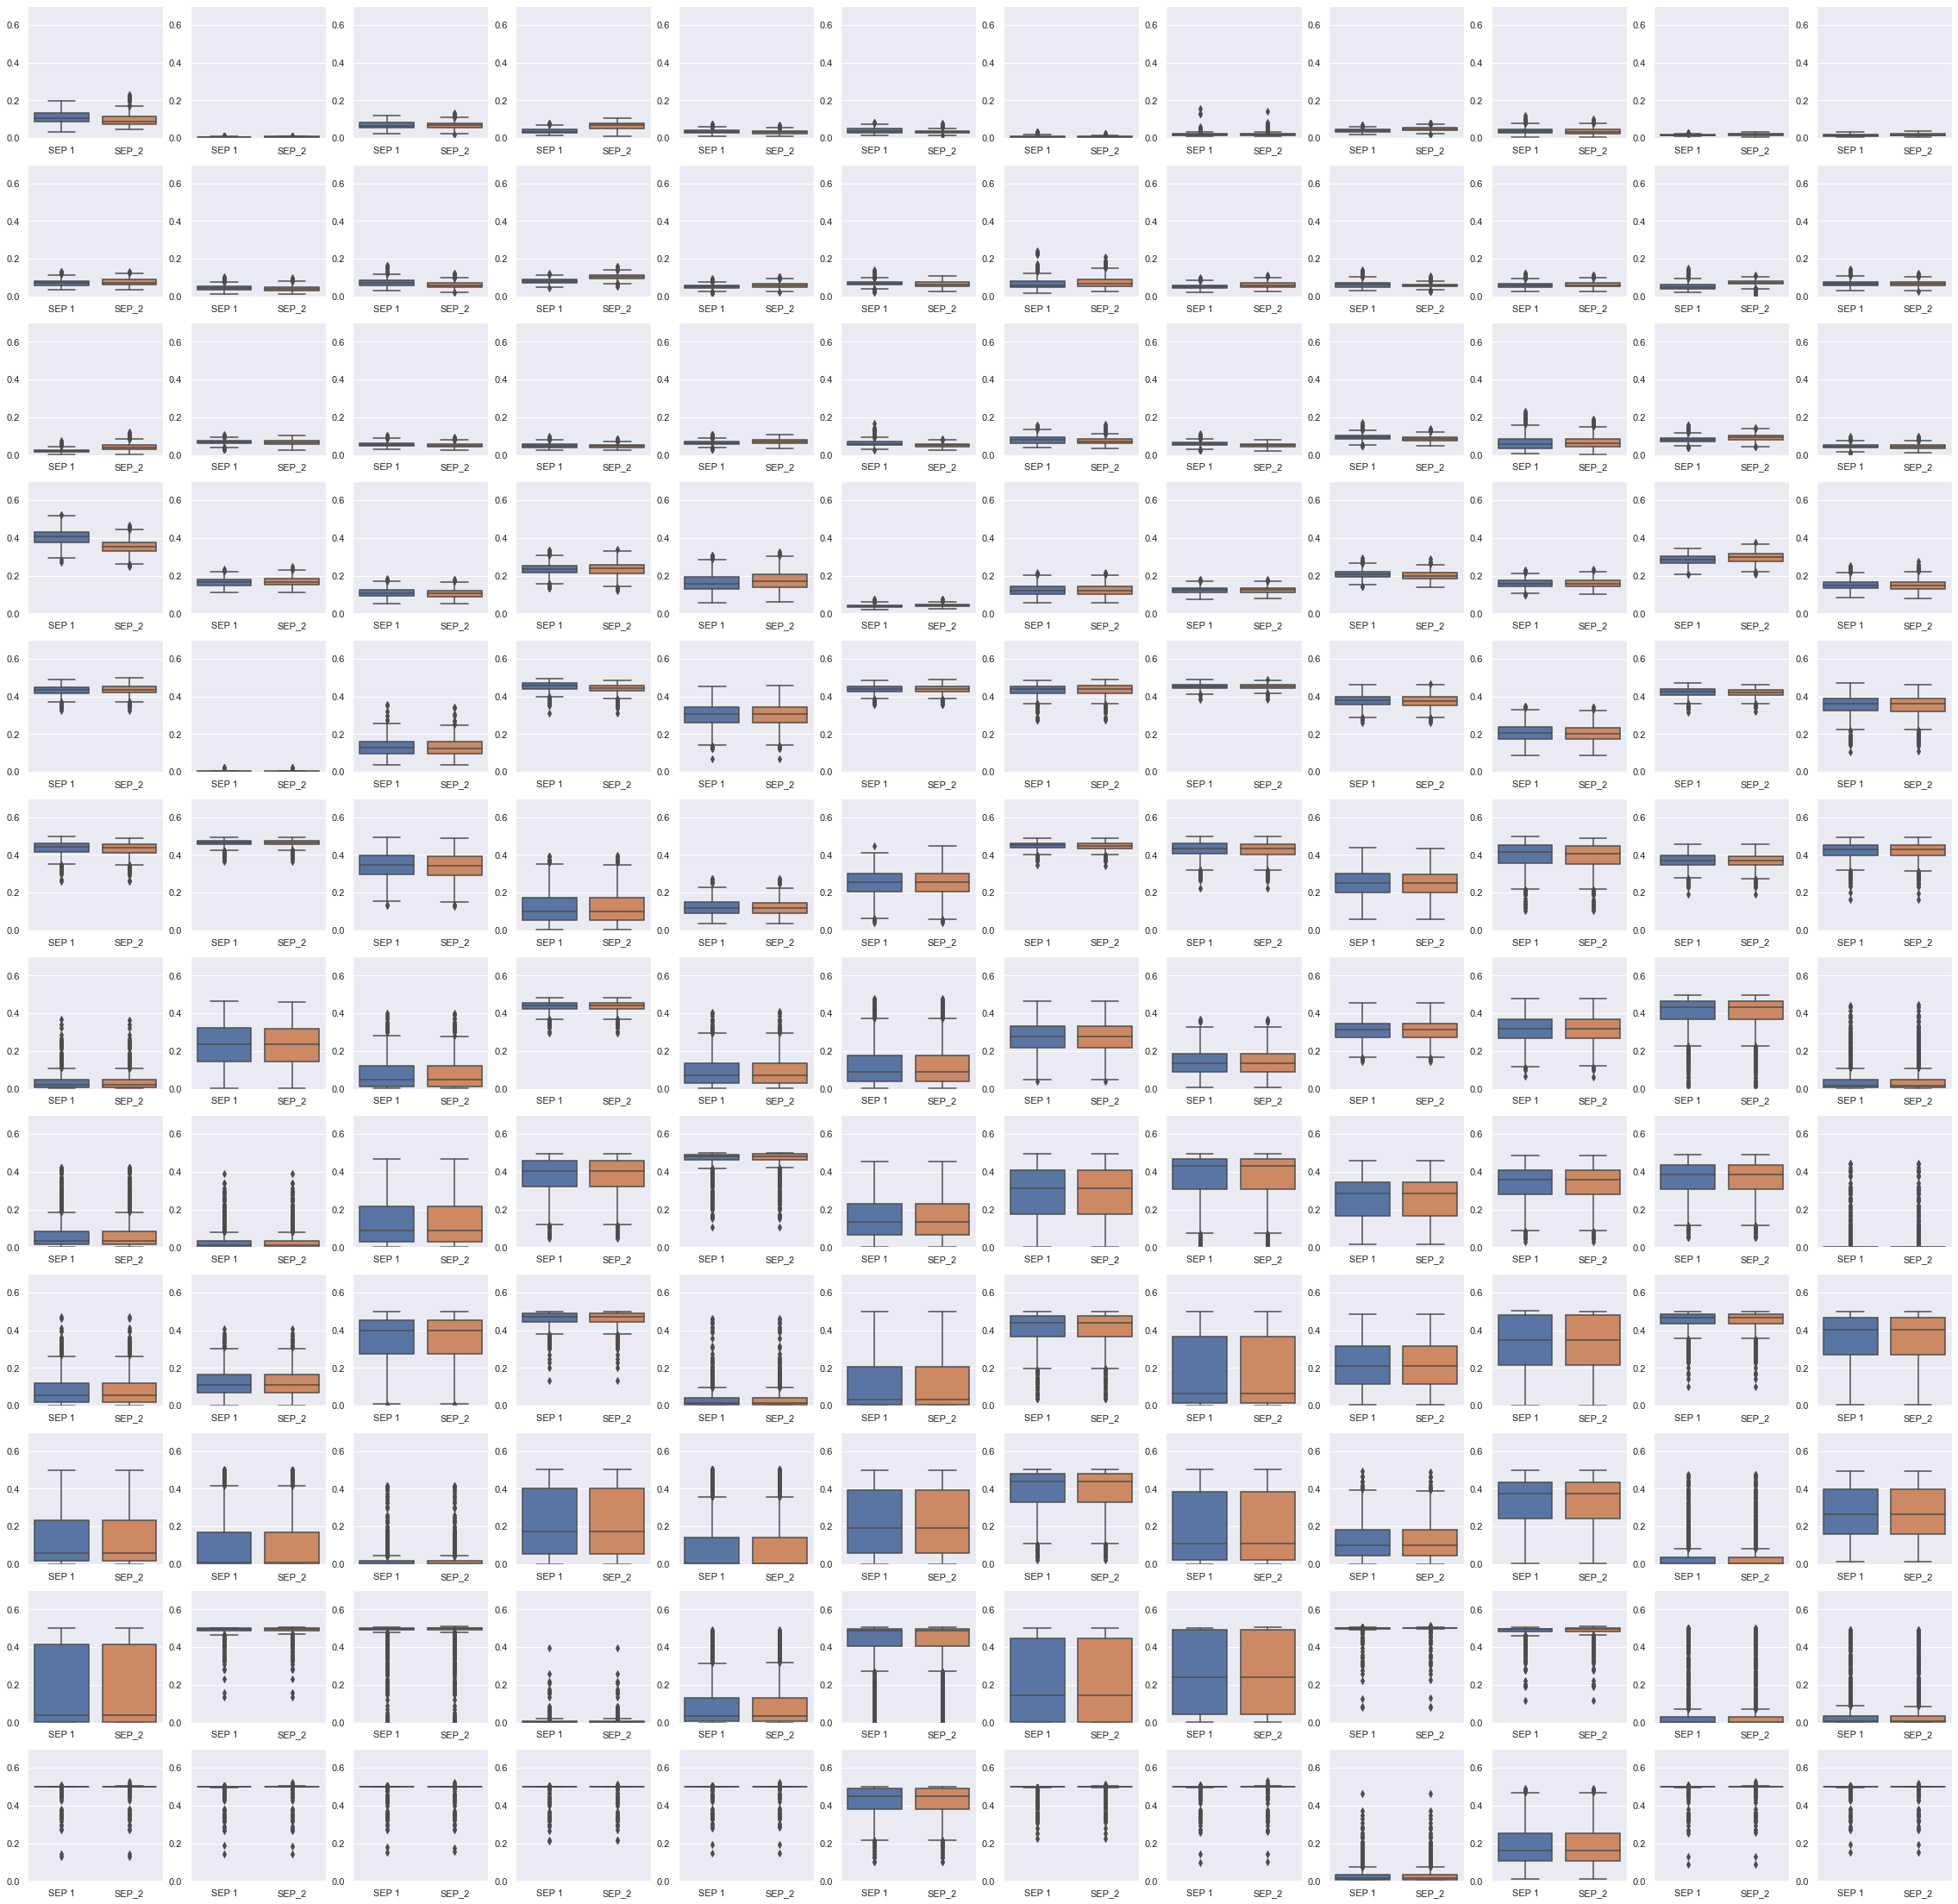

In [7]:
fig, axes = plt.subplots(12,12, figsize=(40,40))
for layer in range(12):
    for head in range(12):
        ax = axes[layer, head]
        ax.set_ylim(0, 0.7)
        sns.boxplot(x = d[(layer, head)][1], y = d[(layer, head)][0], ax = ax)

plt.savefig(os.path.join(graph_folder, "SEP_attention.png"))

## Functions for the Study

In [12]:
def sep_criterion(sep_tr,sentences=sentences, masks=masks, msg = False):
    y_hat = []
    y = []
    for i in tqdm(range(len(sentences))):
        sent = sentences[i, :].clone().detach()[None, :]
        mk = masks[i, :].clone().detach()[None, :]
        raw_attention_inst = RawAttention(model=model,
                                          input_ids=sent,
                                          attention_mask=mk,
                                          test_mod=False
                                          )

        # search for the right sentence in the snli dataset
        j = 0
        while j < e_snli_data.shape[0] and raw_attention_inst.tokens != eval(e_snli_data["tok_sent"][j]):
            j += 1

        try :
            # update the annotation list
            annot = eval(e_snli_data.hg_goal[j])
            y += annot

            # construction of the attention_score based on the SEP criterion
            sep_idx = np.where(np.array(raw_attention_inst.tokens)=="[SEP]")[0]
            attention_score = torch.zeros(len(raw_attention_inst.tokens))
            for layer in range(12):
                for head in range(12):
                    buff = raw_attention_inst.attention_tensor[0, layer, head, 0, :]
                    test = (buff[sep_idx[0]].item() + buff[sep_idx[1]].item()) / 2 # mean of the two values
                    if test < sep_tr: # this is the criterion to proceed the head selection
                        attention_score += buff
            # transform to a list
            attention_score = list(normalize_attention(tokens=raw_attention_inst.tokens,
                                                       attention=attention_score).detach().numpy())
            y_hat += attention_score


        except Exception as e:
            if msg :
                print(e)
            else :
                pass
    return {"y" : y, "y_hat": y_hat}

In [13]:
def create_row(y, y_hat, metrics):
    row = []
    tr = np.linspace(0, 1, 50)
    for m in metrics :
        if m != "roc_auc_score" and m != "jaccard_score" and m != "average_precision_score":
            ar = [] # --> calculus of the metrics
            for t in tr:
                buff = 1 * (np.array(y_hat)>=t)
                ar.append(eval(m)(y, buff))
            row.append(auc(tr, ar))
        else:
            row.append(eval(m)(y, y_hat))

    return row

## Calculus for multiple Threshold

In [16]:
rows = []
evaluation_metrics = ["f1_score", "precision_score", "recall_score", "roc_auc_score", "jaccard_score", "average_precision_score"]

# set the header for the table of statistics
h1 = ["au_"+x+"_curve" for x in ["f1", "PR", "RC"]]

h2 = ["roc_auc_score", "jaccard_score", "AUPRC"]
rows.append(["sep_tr"] + h1 + h2)


for sep_tr in [0.0001, 0.001, 0.005, 0.01, 0.1, 0.5, 0.6, 1]:
    dir = os.path.join(graph_folder, f"sep_{sep_tr}_{keep_neutral}_criterion.pickle")
    if os.path.exists(dir) and os.path.getsize(dir) != 0:
        print(">> the files already exist in the environment >> loading the files ...", end="")
        with open(dir, "rb") as f:
            d = pickle.load(f)
            y = d["y"]
            y_hat = d["y_hat"]
        print(" loading finished")
    else :
        with open(dir, "wb") as f:
            print(">> the file doesn't exist >> downloading >> ", end=" ")
            d = sep_criterion(sep_tr=sep_tr, msg=False)
            print(" >> downloading finished !")
            y = d["y"]
            y_hat = d["y_hat"]
            pickle.dump(d, f)

    rows.append([sep_tr] + create_row(y, y_hat, evaluation_metrics))

>> the files already exist in the environment >> loading the files ... loading finished
>> the files already exist in the environment >> loading the files ... loading finished
>> the files already exist in the environment >> loading the files ... loading finished
>> the files already exist in the environment >> loading the files ... loading finished
>> the files already exist in the environment >> loading the files ... loading finished
>> the files already exist in the environment >> loading the files ... loading finished
>> the files already exist in the environment >> loading the files ... loading finished
>> the files already exist in the environment >> loading the files ... loading finished


In [17]:
print(tabulate(rows, headers="firstrow"))

  sep_tr    au_f1_curve    au_PR_curve    au_RC_curve    roc_auc_score    jaccard_score     AUPRC
--------  -------------  -------------  -------------  ---------------  ---------------  --------
  0.0001       0.263367       0.545813       0.183976         0.651269         0.153924  0.354104
  0.001        0.313298       0.542201       0.242898         0.700404         0.194496  0.398092
  0.005        0.337327       0.569121       0.278257         0.732143         0.215202  0.435376
  0.01         0.340758       0.582224       0.28469          0.733827         0.21768   0.443768
  0.1          0.36424        0.569795       0.366723         0.752565         0.234137  0.47327
  0.5          0.368137       0.565681       0.382771         0.764456         0.2377    0.479948
  0.6          0.368137       0.565681       0.382771         0.764456         0.2377    0.479948
  1            0.368137       0.565681       0.382771         0.764456         0.2377    0.479948


## Table for the ERASER Benchmark

For the eraser benchmark

In [18]:
def create_eraser_row(y, y_hat, metrics):
    row = []
    tr = 0.5
    for m in metrics :
        if m != "roc_auc_score":
            buff = 1 * (np.array(y_hat)>=0.5)
            row.append(eval(m)(y, buff))
        else:
            row.append(eval(m)(y, y_hat))

    return row

In [19]:
evaluation_metrics = ["f1_score", "precision_score", "recall_score", "roc_auc_score", "jaccard_score"]
rows = []
rows.append(["sep_tr"] + evaluation_metrics)
for sep_tr in [0.0001, 0.001, 0.005, 0.01, 0.1, 0.5, 0.6, 1]:
    dir = os.path.join(graph_folder, f"sep_{sep_tr}_{keep_neutral}_criterion.pickle")

    if os.path.exists(dir) and os.path.getsize(dir) != 0:
        print(">> the files already exist in the environment >> loading the files ...", end="")
        with open(dir, "rb") as f:
            d = pickle.load(f)
            y = d["y"]
            y_hat = d["y_hat"]
        print(" loading finished")
    else :
        with open(dir, "wb") as f:
            print(">> the file doesn't exist >> downloading >> ", end=" ")
            d = sep_criterion(sep_tr=sep_tr, msg=False)
            print(" >> downloading finished !")
            y = d["y"]
            y_hat = d["y_hat"]
            pickle.dump(d, f)

    rows.append([sep_tr] + create_eraser_row(y, y_hat, evaluation_metrics))

>> the files already exist in the environment >> loading the files ... loading finished
>> the files already exist in the environment >> loading the files ... loading finished
>> the files already exist in the environment >> loading the files ... loading finished
>> the files already exist in the environment >> loading the files ... loading finished
>> the files already exist in the environment >> loading the files ... loading finished
>> the files already exist in the environment >> loading the files ... loading finished
>> the files already exist in the environment >> loading the files ... loading finished
>> the files already exist in the environment >> loading the files ... loading finished


In [20]:
print(tabulate(rows, headers="firstrow"))

  sep_tr    f1_score    precision_score    recall_score    roc_auc_score    jaccard_score
--------  ----------  -----------------  --------------  ---------------  ---------------
  0.0001    0.266179           0.557669        0.174808         0.651269         0.153521
  0.001     0.312094           0.554791        0.217115         0.700404         0.1849
  0.005     0.327519           0.584486        0.2275           0.732143         0.195829
  0.01      0.332869           0.604863        0.229615         0.733827         0.199666
  0.1       0.379448           0.612779        0.274808         0.752565         0.234147
  0.5       0.383724           0.608605        0.280192         0.764456         0.237412
  0.6       0.383724           0.608605        0.280192         0.764456         0.237412
  1         0.383724           0.608605        0.280192         0.764456         0.237412
